In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

b1 = unpickle('data_batch_1')
b2 = unpickle('data_batch_2')
b3 = unpickle('data_batch_3')
b4 = unpickle('data_batch_4')
b5 = unpickle('data_batch_5')
bt = unpickle('test_batch')
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [3]:
X_t = bt[b'data'].reshape(len(bt[b'data']),3,32,32).transpose(0,2,3,1)
y_t = bt[b'labels']
y_t = np.array(y_t).reshape((len(bt[b'data']),))

airplane


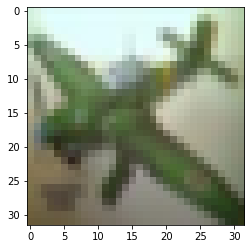

In [4]:
plt.imshow(X_t[27])
print(labels[y_t[27]])

dog


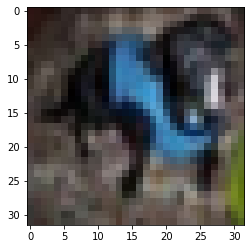

In [5]:
X_1 = b1[b'data'].reshape(len(b1[b'data']),3,32,32).transpose(0,2,3,1)
y_1 = b1[b'labels']
X_2 = b2[b'data'].reshape(len(b1[b'data']),3,32,32).transpose(0,2,3,1)
y_2 = b2[b'labels']
X_3 = b3[b'data'].reshape(len(b1[b'data']),3,32,32).transpose(0,2,3,1)
y_3 = b3[b'labels']
X_4 = b4[b'data'].reshape(len(b1[b'data']),3,32,32).transpose(0,2,3,1)
y_4 = b4[b'labels']
X_5 = b5[b'data'].reshape(len(b1[b'data']),3,32,32).transpose(0,2,3,1)
y_5 = b5[b'labels']
#Xs = [X_1,X_2,X_3,X_4,X_5]
X_ = np.stack([X_1,X_2,X_3,X_4,X_5],axis=0).reshape((50000,32,32,3))
ys = [np.array(y_1).reshape((10000,1)),np.array(y_2).reshape((10000,1)),np.array(y_3).reshape((10000,1)),np.array(y_4).reshape((10000,1)),np.array(y_5).reshape((10000,1))]
y_train = np.stack(ys,axis=0).reshape((50000,))


plt.imshow(X_[27])
print(labels[y_train[27]])

In [6]:
len(X_)

50000

In [7]:
def rgb2bw(img):
    r,g,b = img[:,:,0],img[:,:,1],img[:,:,2]
    #return  0.5*r + 0.7*g + 0.1*b
    return 0.2989 * r + 0.5870 * g + 0.1140 * b
X_train = np.array([rgb2bw(img) for img in X_])
X_test = np.array([rgb2bw(img) for img in X_t])

In [8]:
class Conv:
    def __init__(self,num_filters,kernel_size = 3,padding=0, strides=(1,1)):
        self.kernel_size = kernel_size
        self.filters = np.random.randn(num_filters, self.kernel_size, self.kernel_size) / 9
        self.padding = padding
        self.strides = strides
        
        
    def iterate_regions(self, image):
        '''
        Generates all possible (self.kernel_size x self.kernel_size) image regions.
        - image is a 2d numpy array.
        '''
        h, w = image.shape

        for i in range(h - self.kernel_size-1):
            for j in range(w - self.kernel_size-1):
                im_region = image[i:(i + self.kernel_size), j:(j + self.kernel_size)]
                yield im_region, i, j
    
    def forward(self, img):
        '''
        Performs a forward pass of the conv layer using the given input image.
        Returns a 3d numpy array with dimensions (h, w, num_filters).
        - input is a 2d numpy array
        '''
        if self.padding != 0:
            imagepadded = np.zeros((img.shape[0] + self.padding*2, img.shape[1] + self.padding*2))
            imagepadded[int(self.padding):int(-1 * self.padding), int(self.padding):int(-1 * self.padding)] = img
        else:
            imagepadded = img
        
        self.last_input = imagepadded

        h, w = imagepadded.shape
        output = np.zeros(((h - self.kernel_size-1), (w - self.kernel_size-1), len(self.filters)))
        

        for im_region, i, j in self.iterate_regions(imagepadded):
            output[i, j] = np.sum(im_region * self.filters, axis=(1, 2))

        return output
    
    
    def backprop(self, d_L_d_out, learn_rate):
        '''
        Performs a backward pass of the conv layer.
        - d_L_d_out is the loss gradient for this layer's outputs.
        - learn_rate is a hyperparameter.
        '''
        d_L_d_filters = np.zeros(self.filters.shape)

        for im_region, i, j in self.iterate_regions(self.last_input):
            for f in range(len(self.filters)):
                d_L_d_filters[f] += d_L_d_out[i, j, f] * im_region

        # Update filters
        self.filters -= learn_rate * d_L_d_filters

        return None
        

In [9]:
class MaxPool2:
    def __init__(self,kernel_size = 3,padding=0, strides=(1,1)):
        self.kernel_size = kernel_size
        self.padding = padding
        self.strides = strides
    
    def iterate_regions(self, image):
        '''
        Generates non-overlapping (kernel_size x kernel_size) image regions to pool over.
        - image is a 2d numpy array
        '''
        h, w, _ = image.shape
        new_h = h // 2
        new_w = w // 2

        for i in range(new_h):
            for j in range(new_w):
                im_region = image[(i * 2):(i * 2 + 2), (j * 2):(j * 2 + 2)]
                yield im_region, i, j

    def forward(self, img):
        '''
        Performs a forward pass of the maxpool layer using the given input.
        Returns a 3d numpy array with dimensions (h // 2, w // 2, num_filters).
        - input is a 3d numpy array with dimensions (h, w, num_filters)
        '''
        if self.padding != 0:
            imagepadded = np.zeros((img.shape[0] + self.padding*2, img.shape[1] + self.padding*2))
            imagepadded[int(self.padding):int(-1 * self.padding), int(self.padding):int(-1 * self.padding)] = img
        else:
            imagepadded = img
            
        self.last_input = imagepadded

        h, w, num_filters = imagepadded.shape
        
        output = np.zeros((h // (self.kernel_size-1), w // (self.kernel_size-1), num_filters))

        for im_region, i, j in self.iterate_regions(imagepadded):
            output[i, j] = np.amax(im_region, axis=(0, 1))

        return output

    def backprop(self, d_L_d_out):
        '''
        Performs a backward pass of the maxpool layer.
        Returns the loss gradient for this layer's inputs.
        - d_L_d_out is the loss gradient for this layer's outputs.
        '''
        d_L_d_input = np.zeros(self.last_input.shape)

        for im_region, i, j in self.iterate_regions(self.last_input):
            h, w, f = im_region.shape
            amax = np.amax(im_region, axis=(0, 1))

            for i2 in range(h):
                for j2 in range(w):
                    for f2 in range(f):
                # If this pixel was the max value, copy the gradient to it.
                        if im_region[i2, j2, f2] == amax[f2]:
                            d_L_d_input[i * 2 + i2, j * 2 + j2, f2] = d_L_d_out[i, j, f2]

        return d_L_d_input

In [10]:
class Softmax:
    # A standard fully-connected layer with softmax activation.
    def __init__(self, input_len, nodes):
        # We divide by input_len to reduce the variance of our initial values
        self.weights = np.random.randn(input_len, nodes) / input_len
        self.biases = np.zeros(nodes)

    def forward(self, inp):
        '''
        Performs a forward pass of the softmax layer using the given input.
        Returns a 1d numpy array containing the respective probability values.
        - input can be any array with any dimensions.
        '''
        self.last_input_shape = inp.shape #14x14x16
        #print(inp.shape)
        
        inp = inp.flatten()
        #print(inp.shape)
        
        self.last_input = inp

        totals = np.dot(inp, self.weights) + self.biases
        self.last_totals = totals

        return np.exp(totals)/ np.sum(np.exp(totals), axis=0)

    def backprop(self, d_L_d_out, learn_rate):
        '''
        Performs a backward pass of the softmax layer.
        Returns the loss gradient for this layer's inputs.
        - d_L_d_out is the loss gradient for this layer's outputs.
        - learn_rate is a float.
        '''
        # We know only 1 element of d_L_d_out will be nonzero
        for i, gradient in enumerate(d_L_d_out):
            if gradient == 0:
                continue

            # e^totals
            t_exp = np.exp(self.last_totals)

            # Sum of all e^totals
            S = np.sum(t_exp)

            # Gradients of out[i] against totals
            d_out_d_t = -t_exp[i] * t_exp / (S ** 2)
            d_out_d_t[i] = t_exp[i] * (S - t_exp[i]) / (S ** 2)

            # Gradients of totals against weights/biases/input
            d_t_d_w = self.last_input
            d_t_d_b = 1
            d_t_d_inputs = self.weights

            # Gradients of loss against totals
            d_L_d_t = gradient * d_out_d_t

            # Gradients of loss against weights/biases/input
            d_L_d_w = d_t_d_w[np.newaxis].T @ d_L_d_t[np.newaxis]
            d_L_d_b = d_L_d_t * d_t_d_b
            d_L_d_inputs = d_t_d_inputs @ d_L_d_t

            # Update weights / biases
            self.weights -= learn_rate * d_L_d_w
            self.biases -= learn_rate * d_L_d_b

            return d_L_d_inputs.reshape(self.last_input_shape)

In [11]:
train_images = X_train
train_labels = y_train
test_images = X_test
test_labels = y_t
f_loss = []
f_acc = []

In [14]:
conv = Conv(num_filters=16)                  # 32x32x1 -> 28x28x16
pool = MaxPool2()                   # 28x28x16 -> 14x14x16

softmax = Softmax(14 * 14 * 16, 10) # 15x15x16 -> 10

def forward(image, label):
    '''
    Completes a forward pass of the CNN and calculates the accuracy and
    cross-entropy loss.
    - image is a 2d numpy array
    - label is a digit
    '''
    # We transform the image from [0, 255] to [-0.5, 0.5] to make it easier
    # to work with. This is standard practice.
    out = conv.forward((image / 255) - 0.5)
    out = pool.forward(out)
    out = softmax.forward(out)
    
    loss = 0
    acc = 0

    # Calculate cross-entropy loss and accuracy. np.log() is the natural log.
    for i in range(len(out)):
        if i!=label:
            loss -= np.log(1-out[i])
        else:
            loss -= np.log(out[label])
    
    acc = 1 if np.argmax(out) == label else 0

    return out, loss, acc

def train(im, label, lr=.0005):
    '''
    Completes a full training step on the given image and label.
    Returns the cross-entropy loss and accuracy.
    - image is a 2d numpy array
    - label is a digit
    - lr is the learning rate
    '''
    # Forward
    out, loss, acc = forward(im, label)

    # Calculate initial gradient
    gradient = np.zeros(10)
    gradient[label] = -1 / out[label]

    # Backprop
    gradient = softmax.backprop(gradient, lr)
    gradient = pool.backprop(gradient)
    gradient = conv.backprop(gradient, lr)

    return loss, acc

print('MNIST CNN initialized!')


# Train the CNN for 3 epochs
for epoch in range(8):
    print('--- Epoch %d begins---' % (epoch + 1))

    # Shuffle the training data
    permutation = np.random.permutation(len(train_images))
    train_images = train_images[permutation]
    train_labels = train_labels[permutation]
    train_images = train_images[0:5000]
    train_labels = train_labels[0:5000]

    # Train!
    loss = 0
    num_correct = 0
    
    f_loss.append(loss)
    f_acc.append(num_correct)
    
    for i, (im, label) in enumerate(zip(train_images, train_labels)):
        if i % 100 == 99:
            print('[Step %d] Past 100 steps: Average Loss %.3f | Accuracy: %.3f  | progress precent: %.2f' %
                (i + 1, loss / 100, num_correct/100,((i+1)/len(train_images))*100))
            loss = 0
            num_correct = 0

        l, acc = train(im, label)
        loss += l
        f_loss[epoch] += l
        num_correct += acc
        f_acc[epoch] += acc
    print("---Epoch %d ends---"% (epoch + 1))
    print('Average Loss of epoch : %.3f | Accuracy : %.3f'% (f_loss[epoch]/5000,f_acc[epoch]/5000))
    


MNIST CNN initialized!
--- Epoch 1 begins---
[Step 100] Past 100 steps: Average Loss 3.217 | Accuracy: 0.170  | progress precent: 2.00
[Step 200] Past 100 steps: Average Loss 3.245 | Accuracy: 0.160  | progress precent: 4.00
[Step 300] Past 100 steps: Average Loss 3.240 | Accuracy: 0.220  | progress precent: 6.00
[Step 400] Past 100 steps: Average Loss 3.239 | Accuracy: 0.170  | progress precent: 8.00
[Step 500] Past 100 steps: Average Loss 3.242 | Accuracy: 0.190  | progress precent: 10.00
[Step 600] Past 100 steps: Average Loss 3.231 | Accuracy: 0.230  | progress precent: 12.00
[Step 700] Past 100 steps: Average Loss 3.225 | Accuracy: 0.300  | progress precent: 14.00
[Step 800] Past 100 steps: Average Loss 3.226 | Accuracy: 0.210  | progress precent: 16.00
[Step 900] Past 100 steps: Average Loss 3.225 | Accuracy: 0.200  | progress precent: 18.00
[Step 1000] Past 100 steps: Average Loss 3.230 | Accuracy: 0.190  | progress precent: 20.00
[Step 1100] Past 100 steps: Average Loss 3.221 |

[Step 3900] Past 100 steps: Average Loss 3.034 | Accuracy: 0.310  | progress precent: 78.00
[Step 4000] Past 100 steps: Average Loss 2.889 | Accuracy: 0.270  | progress precent: 80.00
[Step 4100] Past 100 steps: Average Loss 2.932 | Accuracy: 0.280  | progress precent: 82.00
[Step 4200] Past 100 steps: Average Loss 3.009 | Accuracy: 0.280  | progress precent: 84.00
[Step 4300] Past 100 steps: Average Loss 3.002 | Accuracy: 0.270  | progress precent: 86.00
[Step 4400] Past 100 steps: Average Loss 3.055 | Accuracy: 0.210  | progress precent: 88.00
[Step 4500] Past 100 steps: Average Loss 3.028 | Accuracy: 0.260  | progress precent: 90.00
[Step 4600] Past 100 steps: Average Loss 3.117 | Accuracy: 0.300  | progress precent: 92.00
[Step 4700] Past 100 steps: Average Loss 2.886 | Accuracy: 0.280  | progress precent: 94.00
[Step 4800] Past 100 steps: Average Loss 3.095 | Accuracy: 0.270  | progress precent: 96.00
[Step 4900] Past 100 steps: Average Loss 2.986 | Accuracy: 0.330  | progress pre

[Step 2700] Past 100 steps: Average Loss 3.083 | Accuracy: 0.230  | progress precent: 54.00
[Step 2800] Past 100 steps: Average Loss 2.937 | Accuracy: 0.320  | progress precent: 56.00
[Step 2900] Past 100 steps: Average Loss 2.938 | Accuracy: 0.280  | progress precent: 58.00
[Step 3000] Past 100 steps: Average Loss 2.852 | Accuracy: 0.350  | progress precent: 60.00
[Step 3100] Past 100 steps: Average Loss 2.905 | Accuracy: 0.300  | progress precent: 62.00
[Step 3200] Past 100 steps: Average Loss 3.001 | Accuracy: 0.260  | progress precent: 64.00
[Step 3300] Past 100 steps: Average Loss 2.777 | Accuracy: 0.420  | progress precent: 66.00
[Step 3400] Past 100 steps: Average Loss 3.033 | Accuracy: 0.260  | progress precent: 68.00
[Step 3500] Past 100 steps: Average Loss 2.954 | Accuracy: 0.280  | progress precent: 70.00
[Step 3600] Past 100 steps: Average Loss 2.993 | Accuracy: 0.290  | progress precent: 72.00
[Step 3700] Past 100 steps: Average Loss 2.839 | Accuracy: 0.320  | progress pre

[Step 1500] Past 100 steps: Average Loss 2.906 | Accuracy: 0.320  | progress precent: 30.00
[Step 1600] Past 100 steps: Average Loss 2.973 | Accuracy: 0.300  | progress precent: 32.00
[Step 1700] Past 100 steps: Average Loss 2.824 | Accuracy: 0.420  | progress precent: 34.00
[Step 1800] Past 100 steps: Average Loss 2.903 | Accuracy: 0.290  | progress precent: 36.00
[Step 1900] Past 100 steps: Average Loss 2.932 | Accuracy: 0.240  | progress precent: 38.00
[Step 2000] Past 100 steps: Average Loss 2.824 | Accuracy: 0.310  | progress precent: 40.00
[Step 2100] Past 100 steps: Average Loss 2.903 | Accuracy: 0.310  | progress precent: 42.00
[Step 2200] Past 100 steps: Average Loss 2.896 | Accuracy: 0.290  | progress precent: 44.00
[Step 2300] Past 100 steps: Average Loss 2.963 | Accuracy: 0.270  | progress precent: 46.00
[Step 2400] Past 100 steps: Average Loss 2.943 | Accuracy: 0.340  | progress precent: 48.00
[Step 2500] Past 100 steps: Average Loss 2.842 | Accuracy: 0.340  | progress pre

[Step 300] Past 100 steps: Average Loss 3.135 | Accuracy: 0.190  | progress precent: 6.00
[Step 400] Past 100 steps: Average Loss 2.804 | Accuracy: 0.350  | progress precent: 8.00
[Step 500] Past 100 steps: Average Loss 2.961 | Accuracy: 0.230  | progress precent: 10.00
[Step 600] Past 100 steps: Average Loss 2.815 | Accuracy: 0.300  | progress precent: 12.00
[Step 700] Past 100 steps: Average Loss 2.689 | Accuracy: 0.380  | progress precent: 14.00
[Step 800] Past 100 steps: Average Loss 2.778 | Accuracy: 0.390  | progress precent: 16.00
[Step 900] Past 100 steps: Average Loss 2.819 | Accuracy: 0.360  | progress precent: 18.00
[Step 1000] Past 100 steps: Average Loss 2.777 | Accuracy: 0.360  | progress precent: 20.00
[Step 1100] Past 100 steps: Average Loss 2.862 | Accuracy: 0.380  | progress precent: 22.00
[Step 1200] Past 100 steps: Average Loss 2.679 | Accuracy: 0.390  | progress precent: 24.00
[Step 1300] Past 100 steps: Average Loss 2.859 | Accuracy: 0.270  | progress precent: 26.

[Step 4200] Past 100 steps: Average Loss 2.771 | Accuracy: 0.390  | progress precent: 84.00
[Step 4300] Past 100 steps: Average Loss 2.742 | Accuracy: 0.410  | progress precent: 86.00
[Step 4400] Past 100 steps: Average Loss 2.801 | Accuracy: 0.410  | progress precent: 88.00
[Step 4500] Past 100 steps: Average Loss 2.855 | Accuracy: 0.310  | progress precent: 90.00
[Step 4600] Past 100 steps: Average Loss 2.848 | Accuracy: 0.350  | progress precent: 92.00
[Step 4700] Past 100 steps: Average Loss 2.928 | Accuracy: 0.310  | progress precent: 94.00
[Step 4800] Past 100 steps: Average Loss 2.747 | Accuracy: 0.390  | progress precent: 96.00
[Step 4900] Past 100 steps: Average Loss 2.861 | Accuracy: 0.290  | progress precent: 98.00
[Step 5000] Past 100 steps: Average Loss 2.854 | Accuracy: 0.260  | progress precent: 100.00
---Epoch 9 ends---
Average Loss of epoch : 2.834 | Accuracy : 0.338


In [30]:
f_loss = np.array(f_loss)[0:8]
f_acc = np.array(f_acc)[0:8]

array([3.89393033, 3.04151252, 2.98705165, 2.95178226, 2.92404654,
       2.89872691, 2.87653066, 2.85564149])

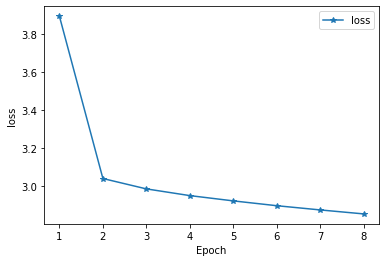

In [47]:
plt.plot(range(1,9,1),f_loss,label='loss',marker ="*")
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.savefig("loss.jpeg")

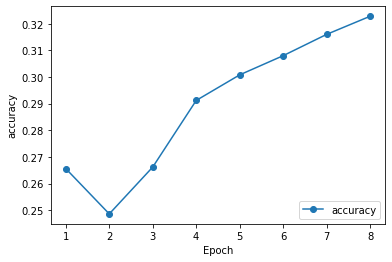

In [48]:
plt.plot(range(1,9,1),f_acc, label = 'accuracy',marker ="o")
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend(loc='lower right')
plt.savefig("accuracy.jpeg")

In [49]:
# Test the CNN

print('\n--- Testing the CNN ---')
loss = 0
num_correct = 0
for i ,(im, label) in enumerate(zip(test_images[0:1000], test_labels[0:1000])):
    _, l, acc = forward(im, label)
    loss += l
    num_correct += acc

num_tests = len(test_images[0:1000])
print('Test Loss:', loss / num_tests)
print('Test Accuracy:', num_correct / num_tests)


--- Testing the CNN ---
Test Loss: 2.8873072249543372
Test Accuracy: 0.319
